In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.colors
from sklearn import cluster
from sklearn.cluster import KMeans,MiniBatchKMeans#引入kmeans
import time
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances_argmin 
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

N = 5000
centers = [[1,1],[1,-1],[-1,-1]]
data1,y = make_blobs(n_samples=N,n_features=2,centers=centers,cluster_std=0.7,random_state = 6)

array([[ 0.5282795 , -1.09472216],
       [ 1.52709954, -2.97073693],
       [ 0.46863389, -1.63505796],
       ...,
       [ 1.31057621, -0.07738157],
       [ 1.06124101,  0.7946983 ],
       [ 1.24273066, -1.30600415]])

In [95]:
km = KMeans(n_clusters=3,init = 'k-means++',random_state=6)
t0 = time.time()
km.fit(data1)
t1 = time.time() - t0
t1
km.labels_[0:10]

array([2, 2, 2, 2, 0, 1, 2, 1, 1, 0])

In [67]:
mini_km = MiniBatchKMeans(n_clusters=3,init = 'k-means++', batch_size=300,random_state = 6)
#batch_size 每次用来计算的样本量
t2 = time.time()
mini_km.fit(data1)
t3 = time.time() - t2
t3

0.03600168228149414

In [96]:
#两种模型结果预测
y1_pre = km.predict(data1)
y2_pre = mini_km.predict(data1)
print(y1_pre[:15])
print(y2_pre[:15])
print('簇中心：',km.cluster_centers_)
print('簇中心：',mini_km.cluster_centers_)
y1_pre[0:10]

[2 2 2 2 0 1 2 1 1 0 2 2 0 2 2]
[0 0 0 0 2 1 0 1 1 2 0 0 2 0 0]
簇中心： [[ 1.01287457  1.03328364]
 [-1.03795042 -1.00685737]
 [ 1.06444674 -1.04489872]]
簇中心： [[ 0.99494731 -1.03524176]
 [-1.08596389 -1.00099169]
 [ 1.01883857  1.02855685]]


array([2, 2, 2, 2, 0, 1, 2, 1, 1, 0])

In [69]:
order = pairwise_distances_argmin(km.cluster_centers_,mini_km.cluster_centers_)

In [70]:
order

array([2, 1, 0], dtype=int64)

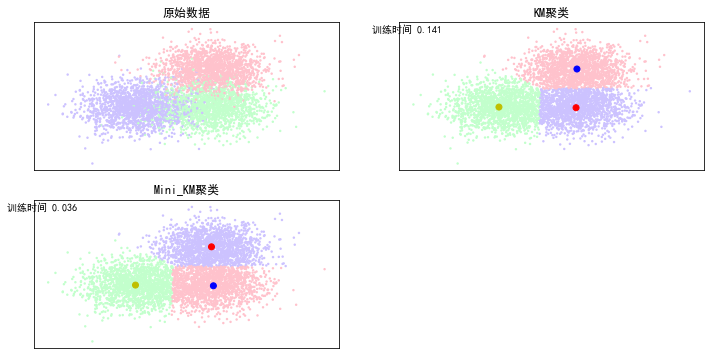

In [71]:
plt.figure(figsize=(12,6),facecolor='w')
plt.subplot(221)
cm = mpl.colors.ListedColormap(['#FFC2CC', '#C2FFCC', '#CCC2FF'])
cm2 = mpl.colors.ListedColormap(list('ryb'))
plt.scatter(data1[:,0],data1[:,1],c = y,cmap =cm,s =6 ,edgecolors='none')
plt.xticks(())
plt.yticks(())#自定义坐标轴刻度
plt.title('原始数据')

plt.subplot(222)
plt.scatter(data1[:,0],data1[:,1],c = y1_pre,cmap =cm,s =6,edgecolors='none' )
plt.scatter(mini_km.cluster_centers_[:,0],mini_km.cluster_centers_[:,1],c = range(3),cmap = cm2 )
plt.xticks(())
plt.yticks(())#自定义坐标轴刻度
plt.title('KM聚类')
plt.text(-4.5,3,'训练时间 %.3f'% t1)

plt.subplot(223)
plt.scatter(data1[:,0],data1[:,1],c = y2_pre,cmap =cm,s =6,edgecolors='none' )
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],c = range(3),cmap = cm2 )
plt.xticks(())
plt.yticks(())#自定义坐标轴刻度
plt.text(-4.5,3,'训练时间 %.3f'% t3)
plt.title('Mini_KM聚类')

plt.show()

In [82]:
different = list(map(lambda x: (x!=0) & (x!=1) & (x!=2),y2_pre))
for k in range(3):
    different += ((y1_pre == k) != (y2_pre == order[k]))
different                

array([False, False, False, ..., False, False, False])

#####两种算法效果评估#####

In [93]:
score_funcs = [
    metrics.adjusted_rand_score,#ARI  调整兰德系数  这四个函数的参数（ 真实标签y，聚类结果y_pre）
    metrics.v_measure_score,#均一性和完整性的加权平均
    metrics.adjusted_mutual_info_score,#AMI  调整互信息
    metrics.mutual_info_score,#互信息
]

for score in score_funcs:
    t0 = time.time()
    km_score = score(y,y1_pre)
    print('KMeans :%s评估结果%.3f,计算耗时%.3fs'% (score.__name__,km_score,time.time()-t0))
    
    t0 = time.time()
    mini_km_score = score(y,y2_pre)
    print('mini_KMeans :%s评估结果%.3f,计算耗时%.3fs'% (score.__name__,mini_km_score,time.time()-t0))

KMeans :adjusted_rand_score评估结果0.710,计算耗时0.002s
mini_KMeans :adjusted_rand_score评估结果0.708,计算耗时0.002s
KMeans :v_measure_score评估结果0.642,计算耗时0.002s
mini_KMeans :v_measure_score评估结果0.642,计算耗时0.002s
KMeans :adjusted_mutual_info_score评估结果0.642,计算耗时0.006s
mini_KMeans :adjusted_mutual_info_score评估结果0.642,计算耗时0.010s
KMeans :mutual_info_score评估结果0.705,计算耗时0.003s
mini_KMeans :mutual_info_score评估结果0.705,计算耗时0.002s


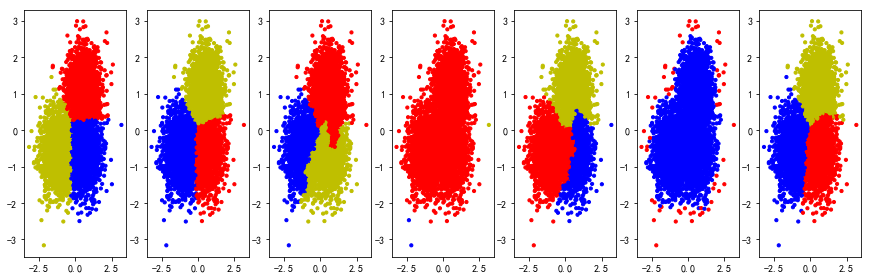

In [107]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
n_cluster = 3  
X2 = StandardScaler().fit_transform(data1)
connectivity = kneighbors_graph(X2,n_neighbors=10,include_self=False)#计算X中k各近邻点 对应的权重
connectivity = 0.5 * (connectivity + connectivity.T)
km = cluster.KMeans(n_clusters=n_cluster)
mbkm = cluster.MiniBatchKMeans(n_clusters=n_cluster)
ward = cluster.AgglomerativeClustering(n_clusters=n_cluster,connectivity=connectivity, linkage='ward')
average = cluster.AgglomerativeClustering(n_clusters=n_cluster,connectivity=connectivity, linkage='average')
birch = cluster.Birch(n_clusters=n_cluster)
dbscan = cluster.DBSCAN(eps=.2)
spectral = cluster.SpectralClustering(n_clusters=n_cluster, eigen_solver='arpack', affinity="nearest_neighbors")
clustering_algorithms = [km, mbkm, ward, average, birch, dbscan, spectral]   
plt.figure(figsize=(15,10),facecolor='w')
plt_i = 1
for algor in clustering_algorithms:
    t0 = time.time()
    algor.fit(X2)
    if hasattr(algor, 'labels_'):
        y_pre = algor.labels_.astype(np.int)
    else:
        y_pre = algor.predict(X2)
    
    plt.subplot(2,7,plt_i)
    plt.scatter(X2[:,0],X2[:,1],c = y_pre,cmap = cm2,s = 10)
    plt_i+=1